In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ACI440
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# EC2, eq. (3.14)

sig_c1, sig_c2, sig_c3, eps_cu1, b, d, A_f, f_fu, E_f, rho_f, f_f = \
 sp.symbols('sigma_c1 sigma_c2 sigma_c3, varepsilon_cu1, b, d, A_f, f_{fu}, E_f, rho_f, f_f', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm = \
sp.symbols('varepsilon_cy, varepsilon_cu, varepsilon, E_cc, f_cm', real=True, nonnegative=True)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k*eta - eta**2)/(1+eta*(k-2))

sig_c_eps_ = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)

In [3]:
# # Comparison to EC2, multi-linear concept

# result2 = np.zeros((len(f_cms), 3))

# for i, f_cm_ in enumerate(f_cms):
#     sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
#                                 f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:EC2.get_eps_cu1(f_cm_- 8)})
#     get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
#     eps_exact = np.linspace(0, eps_cy_, 300)
#     sig_exact = get_sig(eps_exact)
#     area_fine = np.trapz(y=sig_exact, x=eps_exact)
    
#     f_ck = f_cm_ - 8
#     eps_c3 = EC2.get_eps_c3(f_ck)
#     eps_cu3 = EC2.get_eps_cu3(f_ck)
#     area = eps_c3 * f_cm_ / 2 + (eps_cu3 - eps_c3) * f_cm_
    
#     result2[i, 0] = f_cm_
#     result2[i, 1] = area_fine
#     result2[i, 2] = area
# result2

In [4]:
EC2.get_eps_cu1(140),  EC2.get_eps_c1(140)

(0.0044875, 0.0028)

In [5]:
f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])
result = np.zeros((len(f_cms), 3))

for i, f_cm_ in enumerate(f_cms):
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_- 8)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    eps_exact_part_1 = np.linspace(0, eps_cy_, 300)
    sig_exact_part_1 = get_sig(eps_exact_part_1)
    area_exact_part_1 = np.trapz(y=sig_exact_part_1, x=eps_exact_part_1)
    eps_exact_part_2 = np.linspace(eps_cy_, eps_cu_, 300)
    sig_exact_part_2 = get_sig(eps_exact_part_2)
    area_exact_part_2 = np.trapz(y=sig_exact_part_2, x=eps_exact_part_2)
    
    print('area_exact_part_2=', area_exact_part_2)

    sig_eps_c1_new = 2 * area_exact_part_1 / eps_cy_
    sig_eps_c1_scale = sig_eps_c1_new / f_cm_
    
    sig_eps_cu1_new = 2 * area_exact_part_2 / (eps_cu_ - eps_cy_) - sig_eps_c1_new
    sig_eps_cu1_scale = sig_eps_c1_scale if f_cm_ >= 80 else sig_eps_cu1_new / f_cm_
    
    result[i] = [f_cm_, sig_eps_c1_scale, sig_eps_cu1_scale]

result

area_exact_part_2= 0.02877701214730907
area_exact_part_2= 0.03277995980757356
area_exact_part_2= 0.03640007615840574
area_exact_part_2= 0.04043458615206537
area_exact_part_2= 0.04396719132556892
area_exact_part_2= 0.04703380905049359
area_exact_part_2= 0.049662774470494164
area_exact_part_2= 0.05187701624629055
area_exact_part_2= 0.05369545610853977
area_exact_part_2= 0.040706369624936636
area_exact_part_2= 0.028675356080449067
area_exact_part_2= 0.011010187901839687
area_exact_part_2= 0.00023759982078011517
area_exact_part_2= 0.0
area_exact_part_2= 0.0002915995934037693


C:\Users\hspartali\AppData\Local\Temp\ipykernel_12064\3112913915.py:23: RuntimeWarning: invalid value encountered in double_scalars
  sig_eps_cu1_new = 2 * area_exact_part_2 / (eps_cu_ - eps_cy_) - sig_eps_c1_new


array([[ 20.        ,   1.40553767,   0.25961634],
       [ 24.        ,   1.38424032,   0.2966147 ],
       [ 28.        ,   1.36561157,   0.32997541],
       [ 33.        ,   1.34507086,   0.36786299],
       [ 38.        ,   1.32681699,   0.40251767],
       [ 43.        ,   1.31030984,   0.43466001],
       [ 48.        ,   1.29518105,   0.46478674],
       [ 53.        ,   1.28116745,   0.49325478],
       [ 58.        ,   1.2680741 ,   0.52032876],
       [ 63.        ,   1.25575229,   0.65449792],
       [ 68.        ,   1.2440857 ,   0.71985449],
       [ 78.        ,   1.22236429,   0.77367609],
       [ 88.        ,   1.20161951,   1.20161951],
       [ 98.        ,   1.16735515,   1.16735515],
       [108.        ,   1.13352108,   1.13352108]])

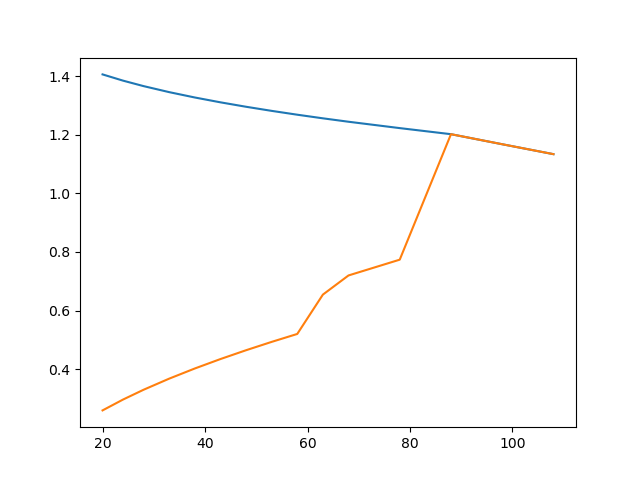

In [75]:
fig1, ax1 = plt.subplots()
ax1.plot(result[:, 0], result[:, 1])
ax1.plot(result[:, 0], result[:, 2])

In [76]:
# Linear regression using numpy

m1, p1 = np.polyfit(result[:, 0], result[:, 1], 1)
sig_cy_scale = m1 * f_cm + p1 # must be <= 1
sig_cy_scale

# exclude > f_cm = 80 from curve fitting
m2, p2 = np.polyfit(result[:, 0][:-3], result[:, 2][:-3], 1)
sig_cu_scale_line = m2 * f_cm + p2 # must be <= 1

# sig_cu_scale = sp.Piecewise(
#         (sig_cu_scale_line, f_cm < 80),
#         (sig_cy_scale, True)
# )
sig_cu_scale = sig_cu_scale_line

sig_cy_scale, sig_cu_scale

(1.44328334402529 - 0.00288035647501513*f_cm,
 0.00883756965553235*f_cm + 0.0684693577318166)

In [74]:
sig_cy_scale

1.44328334402529 - 0.00288035647501513*f_cm

In [8]:
sig_cu_scale

0.00883756965553235*f_cm + 0.0684693577318166

In [9]:
get_sig_cy_scale = sp.lambdify(f_cm, sig_cy_scale, 'numpy')
get_sig_cu_scale_line = sp.lambdify(f_cm, sig_cu_scale_line, 'numpy')
get_sig_cu_scale = sp.lambdify(f_cm, sig_cu_scale, 'numpy')

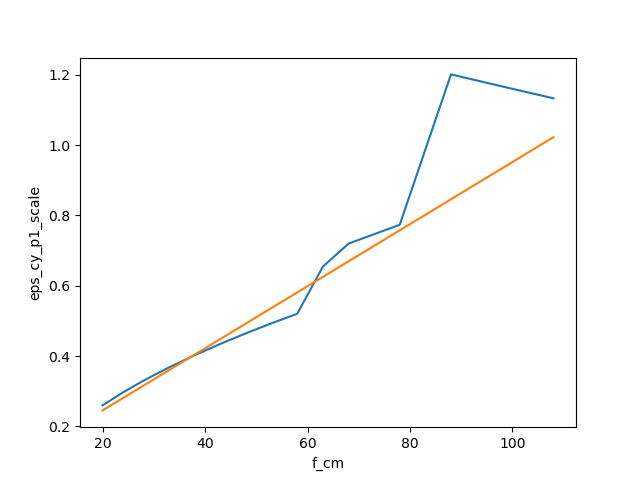

In [10]:
fig1, ax1 = plt.subplots()
f_cm_mid = (result[:, 0][-1] + result[:, 0][0])/2
ax1.set_xlabel('f_cm')
ax1.set_ylabel('eps_cy_p1_scale')

# ax1.plot(result[:, 0], result[:, 1])
# ax1.plot(result[:, 0], get_sig_cy_scale(result[:, 0]))

ax1.plot(result[:, 0], result[:, 2])
ax1.plot(result[:, 0], get_sig_cu_scale(result[:, 0]))

# sig_cy_scale_mid = np.interp(f_cm_mid, result[:, 0], get_sig_cy_scale(result[:, 0]))
# ax1.plot(f_cm_mid, sig_cy_scale_mid, 'o')

area = 0.14433200260337967
area_exact = 0.1443313290935966
area_diff [%] = -0.0004666414334887278


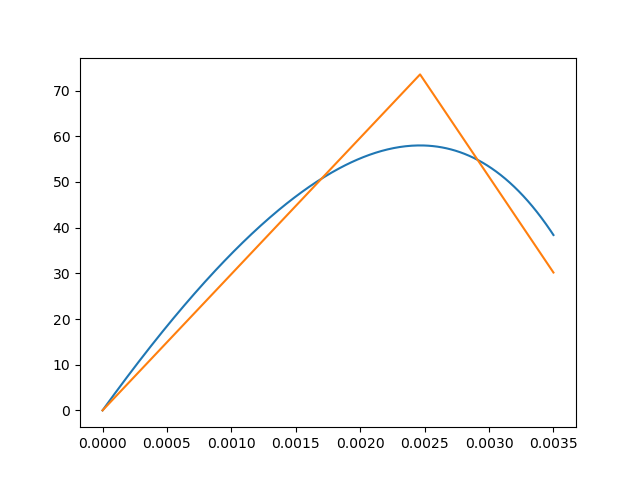

In [11]:
fig, ax = plt.subplots()

for f_cm_ in [58]: # f_cms:
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)

    eps_fine = np.linspace(0, eps_cu_, 300)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    sig_fine = get_sig(eps_fine)
    area_exact = np.trapz(y=sig_fine, x=eps_fine)
    
    sig2_scale_for_f_cm = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][2]
    sig_scale_for_f_cm = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][1]
    eps_coarse = np.array([0., eps_cy_, eps_cu_])
    sig_coarse = np.array([0., f_cm_ * sig_scale_for_f_cm, f_cm_ * sig2_scale_for_f_cm])
    
    area = np.trapz(y=sig_coarse, x=eps_coarse)
    print('area =', area)
    print('area_exact =', area_exact)
    print('area_diff [%] =', (area_exact - area) * 100 / area_exact)
    
    ax.plot(eps_fine, sig_fine)
    ax.plot(eps_coarse, sig_coarse)

# fig.show()

## Deriving $\psi_c, M_n$ equations for the linearized curve

In [12]:
substitute_E_cc_and_eps_cy = False

if substitute_E_cc_and_eps_cy:
    E_cm = 22000 * (f_cm / 10) ** 0.3
    # WARNING, TODO: Instead use 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) ??
    eps_c1 = 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) # 0.001 * 0.7 * f_cm ** 0.31
    eps_cu1 = 0.001 * sp.Piecewise(
        (3.5, f_cm <= 58), 
        (2.8 + 27 * ((98 - f_cm) / 100) ** 4, True)
)
else:
    E_cm = E_cc
    eps_c1 = eps_cy
    eps_cu1 = eps_cu

sig_line = sp.Line(sp.Point(0, 0), sp.Point(eps_c1, f_cm * sig_cy_scale))
sig_line2 = sp.Line(sp.Point(eps_c1, f_cm * sig_cy_scale), sp.Point(eps_cu1, f_cm * sig_cu_scale))

sig_eq_1 = sig_line.equation(x=eps, y=sig_c1)
sig_eq1 = sp.solve(sig_eq_1, sig_c1)[0]

sig_eq_2 = sig_line2.equation(x=eps, y=sig_c2)
sig_eq2 = sp.solve(sig_eq_2, sig_c2)[0]

In [13]:
sig_eq = sp.Piecewise(
        (sig_eq1, eps <= eps_c1), 
        (sig_eq2, True)
)
sig_eq

Piecewise((f_cm*varepsilon*(144328334402529000 - 288035647501513*f_cm)/(100000000000000000*varepsilon_cy), varepsilon <= varepsilon_cy), (f_cm*(1171792613054748*f_cm*varepsilon - 288035647501513*f_cm*varepsilon_cu - 883756965553235*f_cm*varepsilon_cy - 137481398629347340*varepsilon + 144328334402529000*varepsilon_cu - 6846935773181660*varepsilon_cy)/(100000000000000000*(varepsilon_cu - varepsilon_cy)), True))

In [14]:
# The following is valid for any eps in the second descending line in the approximated sig-eps relation
# For f_cm > 80, only the triangle is enough as the trapz doesn't exist because eps_cy = eps_cu

triangle_area = eps_c1 * f_cm * sig_cy_scale / 2
triangle_ce = (eps - eps_c1) + eps_c1 / 3

small_base_trapz = sig_eq.args[1][0]
large_base_trapz = f_cm * sig_cy_scale
h_trapz = eps - eps_c1
trapz_ce_dist_from_large_base = (h_trapz/3) * (large_base_trapz + 2 * small_base_trapz) / (large_base_trapz + small_base_trapz)
trapz_ce_dist_from_large_base = sp.simplify(trapz_ce_dist_from_large_base)
trapz_ce = eps - eps_c1 - trapz_ce_dist_from_large_base
trapz_ce = sp.simplify(trapz_ce)
trapz_area = h_trapz * (small_base_trapz + large_base_trapz) / 2 
trapz_area = sp.simplify(trapz_area)

total_area = triangle_area + trapz_area

ce2_eps = ((trapz_ce * trapz_area) + (triangle_ce * triangle_area)) / total_area
ce2_eps_fraction = ce2_eps / eps
ce2_eps_fraction = sp.simplify(ce2_eps_fraction)
ce2_eps_fraction

(100000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529)*(3*varepsilon - 2*varepsilon_cy)*(varepsilon_cu - varepsilon_cy) + (varepsilon - varepsilon_cy)**2*(-1171792613054748*f_cm*varepsilon + 288035647501513*f_cm*varepsilon_cu + 883756965553235*f_cm*varepsilon_cy + 137481398629347340*varepsilon - 144328334402529000*varepsilon_cu + 6846935773181660*varepsilon_cy + 200000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy)))/(3*varepsilon*(100000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy) + (varepsilon - varepsilon_cy)*(-1171792613054748*f_cm*varepsilon + 288035647501513*f_cm*varepsilon_cu + 883756965553235*f_cm*varepsilon_cy + 137481398629347340*varepsilon - 144328334402529000*varepsilon_cu + 6846935773181660*varepsilon_cy + 100000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy))))

In [18]:
eps_fu = f_fu / E_f
c = d * eps/(eps + eps_fu)
ce2 = ce2_eps_fraction.subs({eps: eps_cu}) * c.subs({eps: eps_cu})
ce2 = sp.simplify(ce2)
ce2

E_f*d*(20000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529)*(3*varepsilon_cu - 2*varepsilon_cy) + (varepsilon_cu - varepsilon_cy)*(-176751393110647*f_cm*varepsilon_cu + 176751393110647*f_cm*varepsilon_cy - 1369387154636332*varepsilon_cu + 1369387154636332*varepsilon_cy + 40000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy)))/(3*(E_f*varepsilon_cu + f_{fu})*(-176751393110647*f_cm*varepsilon_cu + 176751393110647*f_cm*varepsilon_cy - 1369387154636332*varepsilon_cu + 20000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529) + 1369387154636332*varepsilon_cy + 20000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy)))

In [34]:
ce2

E_f*d*(20000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529)*(3*varepsilon_cu - 2*varepsilon_cy) + (varepsilon_cu - varepsilon_cy)*(-176751393110647*f_cm*varepsilon_cu + 176751393110647*f_cm*varepsilon_cy - 1369387154636332*varepsilon_cu + 1369387154636332*varepsilon_cy + 40000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy)))/(3*(E_f*varepsilon_cu + f_{fu})*(-176751393110647*f_cm*varepsilon_cu + 176751393110647*f_cm*varepsilon_cy - 1369387154636332*varepsilon_cu + 20000000000000000*varepsilon_cy*(0.00288035647501513*f_cm - 1.44328334402529) + 1369387154636332*varepsilon_cy + 20000000000000000*(0.00288035647501513*f_cm - 1.44328334402529)*(varepsilon_cu - varepsilon_cy)))

## Balanced reinforcement ratio $\rho_\mathrm{fb}$

In [19]:
F_t = A_f * f_fu
sig_z_area = total_area.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
A_fb = sp.solve(F_t - F_c, A_f)[0]
A_fb = sp.simplify(A_fb)
rho_fb = A_fb / (b * d)
rho_fb

5.0e-18*E_f*f_cm*(595721318051722.0*f_cm*varepsilon_cu - 883756965553235.0*f_cm*varepsilon_cy + 1.51175270175711e+17*varepsilon_cu - 6.84693577318166e+15*varepsilon_cy)/(f_{fu}*(E_f*varepsilon_cu + f_{fu}))

In [20]:
sp.N(rho_fb.subs({f_cm:50, f_fu:2500, E_f:200000, eps_cy:EC2.get_eps_c1(50-8), eps_cu:EC2.get_eps_cu1(50-8)}))

0.00320772788485688

## $M_\mathrm{n}$ for $\rho_\mathrm{f} > \rho_\mathrm{fb}$

In [21]:
F_t = A_f * f_fu
sig_z_area = total_area.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
f_f_sol = sp.solve(F_t - F_c, f_fu)[1].subs({A_f:rho_f * b * d})
f_f_sol = sp.simplify(f_f_sol)

# Note: if f_f > f_fu then FRP reinforcement will fail on tension (most probably a rho_f < rho_fb is used)
f_f_ = sp.Min(f_f_sol, f_fu)
f_f_

Min(f_{fu}, 0.86941149686357*sqrt(E_f)*sqrt(0.330741925857881*E_f*rho_f*varepsilon_cu**2 + 0.00394060032014043*f_cm**2*varepsilon_cu - 0.00584590961554788*f_cm**2*varepsilon_cy + f_cm*varepsilon_cu - 0.0452913744769464*f_cm*varepsilon_cy)/sqrt(rho_f) - 0.5*E_f*varepsilon_cu)

In [22]:
psi_f = f_f / f_fu
psi_f

f_f/f_{fu}

In [31]:
sp.N(f_f_.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, rho_f: 235/(180*400), E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu:EC2.get_eps_cu1(50-8)}))

2475.74694450381

In [25]:
ce2_f_f = ce2.subs({f_fu: f_f})
M_n_2 = A_f * f_f * (d - ce2_f_f)
M_n_2 = sp.simplify(M_n_2)
M_n_2

A_f*d*f_f*(295895656720991.0*E_f*f_cm*varepsilon_cu**2 - 234358522610950.0*E_f*f_cm*varepsilon_cu*varepsilon_cy - 176751393110647.0*E_f*f_cm*varepsilon_cy**2 + 3.16044411897784e+16*E_f*varepsilon_cu**2 + 2.74962797258695e+16*E_f*varepsilon_cu*varepsilon_cy - 1.36938715463634e+15*E_f*varepsilon_cy**2 + 357432790831033.0*f_cm*f_f*varepsilon_cu - 530254179331941.0*f_cm*f_f*varepsilon_cy + 9.07051621054263e+16*f_f*varepsilon_cu - 4.108161463909e+15*f_f*varepsilon_cy)/(357432790831033.0*E_f*f_cm*varepsilon_cu**2 - 530254179331941.0*E_f*f_cm*varepsilon_cu*varepsilon_cy + 9.07051621054263e+16*E_f*varepsilon_cu**2 - 4.108161463909e+15*E_f*varepsilon_cu*varepsilon_cy + 357432790831033.0*f_cm*f_f*varepsilon_cu - 530254179331941.0*f_cm*f_f*varepsilon_cy + 9.07051621054263e+16*f_f*varepsilon_cu - 4.108161463909e+15*f_f*varepsilon_cy)

In [55]:
# packaging common terms
sp.cse(M_n_2)[-1][0]

A_f*d*f_f*(295895656720991.0*f_cm*x0 - 234358522610950.0*f_cm*x2 - 176751393110647.0*f_cm*x7 + 3.16044411897784e+16*x0 + 2.74962797258695e+16*x2 + x6 - 1.36938715463634e+15*x7)/(x0*x1 + 9.07051621054263e+16*x0 - x2*x3 - 4.108161463909e+15*x2 + x6)

## Validation with Mk model


M_u_mk_model = 97.76 kNm

M_u_model = 97.74 kNm !!!

M_u_aci = 81.72 kNm !!!

In [26]:
sp.N(M_n_2.subs({f_f:f_f_}).subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000,  rho_f:250/(400*180), A_f:250, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu:EC2.get_eps_cu1(50-8)}) / 1e6)

97.7389774329745

In [27]:
ACI440.get_M_n(A_f=250, f_fu=2500, E_f=200000, f_c=50, b=400, d=180)

81.72727250760829

In [68]:
sp.N(M_n_2.subs({f_f:f_f_}).subs({f_cm:98.63, b:300, d:90, f_fu:3823.90, E_f:247468.92,  rho_f:28.96/(300*90), A_f:28.96, E_cc:EC2.get_E_cm(98.63-8), eps_cy:EC2.get_eps_c1(98.63-8), eps_cu:EC2.get_eps_cu1(98.63-8)}) / 1e6)

9.45696190057043

In [72]:
28.96/(300*90)

0.0010725925925925927

In [70]:
sp.N(rho_fb.subs({f_f:f_f_}).subs({f_cm:98.63, b:300, d:90, f_fu:3823.90, E_f:247468.92,  rho_f:28.96/(300*90), A_f:28.96, E_cc:EC2.get_E_cm(98.63-8), eps_cy:EC2.get_eps_c1(98.63-8), eps_cu:EC2.get_eps_cu1(98.63-8)}))

0.00229337541127927

In [71]:
ACI440.get_rho_balanced(f_c=98.63, f_fu=3823.9, E_f=247468.92)

0.0023169231194534973

In [84]:
ACI440.get_M_n(A_f=28.96, f_fu=3823.90, E_f=247468.92, f_c=98.63, b=300, d=90)

9.439980300822834

In [28]:
ACI440.get_rho_balanced(f_c=50, f_fu=2500, E_f=200000)

0.0022797235023041475

In [63]:
rho_fb_elg = (0.8095 * 3.5 / (3.5 + eps_fu*1000)) * (1 - 0.416 * 3.5 / (3.5 + eps_fu*1000))
rho_fb_elg

2.83325*(1 - 1.456/(3.5 + 2000*f_{fu}/E_f))/(3.5 + 2000*f_{fu}/E_f)

In [64]:
rho_fb_elg.subs({f_fu:2500, E_f:200000})

0.0943335340104648

## Validation with experiments

**BC2HA** beam from Thériault1998_Effects of FRP Reinforcement Ratio and Concrete Strength on Flexural Behavior of Concrete Beams.pdf

M_u_experiment = 19.7 kNm

M_u_model = 19.7 kNm !!!

M_u_aci = 16 kNm !!!

In [53]:
sp.N(M_n_2.subs({f_f:f_f_}).subs({f_cm:57.2, b:130, d:180-20-6-12.3/2, f_fu:773, E_f:38000,  rho_f:2*np.pi*(12.3/2)**2/(130*(180-20-6-12.3/2)), A_f:2*np.pi*(12.3/2)**2, E_cc:EC2.get_E_cm(57.2-8), eps_cy:EC2.get_eps_c1(57.2-8), eps_cu:EC2.get_eps_cu1(57.2-8)}) / 1e6)

19.7397175346525

In [51]:
ACI440.get_M_n(A_f=2*np.pi*(12.3/2)**2, f_fu=773, E_f=38000, f_c=57.2, b=130, d=180-20-6-12.3/2)

16.014750484294655